<a href="https://colab.research.google.com/github/Zhang-Cheng-76200/Multistep-forecasting-CapsNet-LSTM/blob/main/Multistep_CapsNet_LSTM_DJIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multistage prediction with CAPSNET-LSTM (DJIA)

In [1]:
import keras.backend as K
import tensorflow as tf

import keras
from keras import backend as K
from keras import initializers, layers, models, optimizers, callbacks, utils
from keras.models import load_model
from keras.models import model_from_json

from keras.initializers import glorot_uniform

from keras.initializers import *
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.utils import *

from keras import losses
from keras.utils.io_utils import ask_to_proceed_with_overwrite
from tensorflow.python.platform import tf_logging as logging

import os
import copy
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass




In [2]:
import random

In [3]:
# Set seed
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

In [4]:
# If code is running on TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [5]:
strategy = tf.distribute.TPUStrategy(resolver)

In [6]:
print(tf.__version__)

2.11.0


# Parsing the raw data

A couple of things to note:

- There is no need to save the data points as numpy arrays, regular lists is fine.
- The `time` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `series` list.
- The values of the `series` should be of `float` type. You can use Python's built-in `float` function to ensure this.

Begin by looking at the structure of the xlsx file that contains the data:

In [7]:
from google.colab import drive
drive.mount ('gdrive')

Mounted at gdrive


In [8]:
DJIA_raw = pd.read_excel('/content/gdrive/MyDrive/Multistage/DJIA/DJIA.xlsx')
DJIA_raw

,Date,Open,High,Low,Close,Volume
0,2010-04-01 00:00:00,10430.69,10604.97,10430.69,10583.96,179780000
1,2010-05-01 00:00:00,10584.56,10584.56,10522.52,10572.02,188540000
2,2010-06-01 00:00:00,10564.72,10594.99,10546.55,10573.68,186040000
3,2010-07-01 00:00:00,10571.11,10612.37,10505.21,10606.86,217390000
4,2010-08-01 00:00:00,10606.40,10619.40,10554.33,10618.19,172710000
...,...,...,...,...,...,...
2511,12/24/19,28572.57,28576.80,28503.21,28515.45,86150000
2512,12/26/19,28539.46,28624.10,28535.15,28621.39,155970000
2513,12/27/19,28675.34,28701.66,28608.98,28645.26,182280000
2514,12/30/19,28654.76,28664.69,28428.98,28462.14,181600000


In [9]:
series = DJIA_raw.iloc[:,4] # close price

In [10]:
time = []
for i in range(0, len(series)):
  time.append(i)

A helper function to plot the time series:

In [11]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

The next cell will use functions to compute the `time` and `series` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

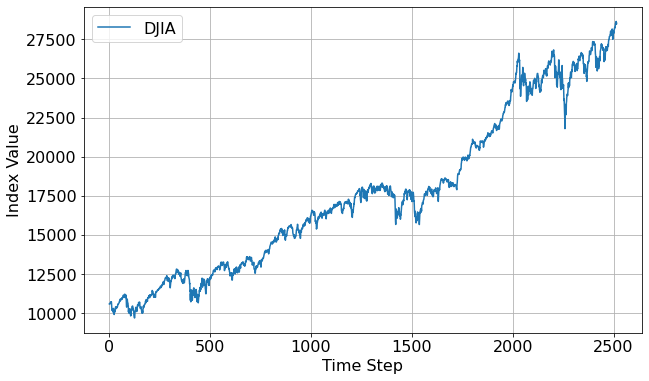

In [12]:
# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME = np.array(time)
    SERIES = np.array(series)
    SPLIT_TIME = int(len(series)*0.1)          # data splitting, the last 20% samples are test set.
    WINDOW_SIZE = 50                                # sequence length
    BATCH_SIZE = 32                                  # batch size

plt.rcParams['font.size'] = '16'
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["DJIA"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Multistage/DJIA/figures/DJIA_original.tif")
plt.show()

In [13]:
series_y = series[G.WINDOW_SIZE:]

# Processing the data

The `train_test_split` and `windowed_dataset` functions:

In [14]:
def train_test_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:-G.SPLIT_TIME]
    series_train = series[:-G.SPLIT_TIME]
    time_test = time[-G.SPLIT_TIME:]
    series_test = series[-G.SPLIT_TIME:]

    return time_train, series_train, time_test, series_test



In [15]:
time_train, series_train, time_test, series_test = train_test_split(G.TIME, series)

In [16]:
# Split the dataset
time_train, series_train, time_test, series_test = train_test_split(G.TIME, G.SERIES)


In [17]:
def min_max_normalization(series):
  series = (series - min(series[:-G.SPLIT_TIME]))/(max(series[:-G.SPLIT_TIME]) - min(series[:-G.SPLIT_TIME]))
  return series

In [18]:

series_norm = min_max_normalization(G.SERIES)



In [19]:
# Create train_set, val_set, and train_val_set. train_set and val_set are used for hyper=parameters tuning, and train_val_set is used for training.
def windowed_dataset_one_step(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


In [20]:
def windowed_dataset_five_step(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 5, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 5))
    ds = ds.map(lambda w: (w[:-5], w[-5:]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


In [21]:
train_set_five_step = windowed_dataset_five_step(series_norm[:-G.SPLIT_TIME], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [22]:
train_set_one_step = windowed_dataset_one_step(series_norm[:-G.SPLIT_TIME], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE)

In [23]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()   
    rmse = tf.math.sqrt(mse).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    mape = tf.keras.metrics.mean_absolute_percentage_error(true_series, forecast).numpy()
    return rmse, mae, mape

In [24]:
def smape(actual, predicted):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE) between two lists of values.
    """
    if len(actual) != len(predicted):
        raise ValueError("Lists must have the same length")
    return 100/len(actual) * sum(2 * abs(a - p) / (abs(a) + abs(p)) for a, p in zip(actual, predicted))

In [25]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [26]:
def reverse_normalization(series, series_train):
  series = series * (max(series_train) - min(series_train)) + min(series_train)
  return series

In [27]:
# Prepare callback

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='mae', factor=0.95,patience=5)

In [28]:
input_shape = (G.WINDOW_SIZE, 1)

In [29]:
K.clear_session()

# Compiling the model


## Defining the model architecture (CapsNet-LSTM)


In [30]:
# Squash function

def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True) 
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


In [31]:
# Dynamic routing (layer)
#    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
#    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
#    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
#    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.

#    :param dim_capsule: dimension of the output vectors of the capsules in this layer
#    :param routings: number of iterations for the routing algorithm 

#@tf.keras.utils.register_keras_serializable() should use this line next time when need to save the model with a custom layer.
class Routing(keras.layers.Layer):

    def __init__(self, dim_capsule = 32 , routings=3, kernel_initializer='glorot_uniform'):
        super(Routing, self).__init__()
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        # build tansform matrix which can convert one primary cap to a vector with the same order as the digit cap.
        # assert len(input_shape) >= 3  # The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]
        
        # Transform matrix
       
        self.W = self.add_weight(shape=[self.input_num_capsule,self.dim_capsule, self.input_dim_capsule],initializer=self.kernel_initializer,name='W')

    def call(self, inputs): #training=None
        # inputs.shape=[input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[input_num_capsule, input_dim_capsule, 1]
        inputs_expand = K.expand_dims(inputs, -1)    

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[None, input_num_capsule, input_dim_capsule, 1]
        # W.shape=[input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first dimension as `batch` dimension,
        # then matmul: [dim_capsule, input_dim_capsule] x [input_dim_capsule, 1] -> [dim_capsule].
        # inputs_hat.shape = [None, input_num_capsule, dim_capsule, 1]     
          
        inputs_hat = K.map_fn(lambda x: K.batch_dot(self.W, x, [2, 1]), elems=inputs_expand) 

        inputs_hat = K.squeeze(inputs_hat, axis = -1)
        # inputs_hat.shape = [None, input_num_capsule, dim_capsule]
       
        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.input_num_capsule])
        
        assert self.routings > 0
        for i in range(self.routings):
            # c.shape=[batch_size, input_num_capsule]
            c = tf.nn.softmax(b, axis=-1)

            # c.shape =  [batch_size, input_num_capsule]
            # inputs_hat.shape=[batch_size, input_num_capsule, dim_capsule]
            # The first dimensions as `batch` dimension,
            # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
            # outputs.shape=[None, dim_capsule]
            
            #outputs = squash(K.batch_dot(c, inputs_hat, [1, 1])) 
            outputs = K.batch_dot(c, inputs_hat, [1, 1])

            if i < self.routings - 1:
                # outputs.shape =  [None, dim_capsule]
                # inputs_hat.shape=[None, input_num_capsule, dim_capsule]
                # The first dimension as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, input_num_capsule]
                b += K.batch_dot(outputs, inputs_hat, [1, 2])
       
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.dim_capsule])

    def get_config(self):
        config = super().get_config()
        config.update({
            "dim_capsule": self.dim_capsule,
            "routings": self.routings,
            "kernel_initializer": self.kernel_initializer,
        })
        return config

### Model training

In [32]:
# Build the model with the default setting. LSTM units = 200, Convolution filters = 256, kernel size = 2, stride = 1, learning rate = 0.0005
def CapsNet_LSTM():
   
    input = tf.keras.layers.Input(shape=input_shape)
      
    # First layer
    conv1d_1 = tf.keras.layers.Conv1D(filters=256, kernel_size=2, strides=1, padding='causal', activation='relu', name = 'conv1d_1')(input)
          
    # Primary caps
  
    unsquashed_caps = tf.keras.layers.Reshape((G.WINDOW_SIZE, 32, 8))(conv1d_1)
    squashed_caps = tf.keras.layers.Lambda(squash)(unsquashed_caps)

    # Digit caps
     
    digit_caps = tf.keras.layers.TimeDistributed(Routing(dim_capsule = 256, routings = 3))(squashed_caps)

    # LSTM layer
    lstm = tf.keras.layers.LSTM(200)(digit_caps)

    # Dense layer

    output = tf.keras.layers.Dense(5)(lstm)

    model = keras.Model(inputs=input, outputs=output, name="capsnet_lstm")

    learning_rate = 0.0005
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=["mae"])

    return model

epoch number for CapsNet-LSTM is 500.

In [33]:

with strategy.scope():
  capsnet_lstm = CapsNet_LSTM()
    # Fit with the entire dataset.
capsnet_lstm.fit(train_set_five_step, epochs=400,callbacks = [reduce_lr])  


Instructions for updating:
Use fn_output_signature instead


Epoch 1/400
70/70 [==============================] - 11s 54ms/step - loss: 0.0036 - mae: 0.0502 - lr: 5.0000e-04
Epoch 2/400
70/70 [==============================] - 2s 27ms/step - loss: 0.0524 - mae: 0.1906 - lr: 5.0000e-04
Epoch 3/400
70/70 [==============================] - 2s 28ms/step - loss: 0.0749 - mae: 0.2280 - lr: 5.0000e-04
Epoch 4/400
70/70 [==============================] - 2s 27ms/step - loss: 0.0237 - mae: 0.1330 - lr: 5.0000e-04
Epoch 5/400
70/70 [==============================] - 2s 27ms/step - loss: 0.0179 - mae: 0.1078 - lr: 5.0000e-04
Epoch 6/400
70/70 [==============================] - 2s 27ms/step - loss: 0.0111 - mae: 0.0797 - lr: 5.0000e-04
Epoch 7/400
70/70 [==============================] - 2s 27ms/step - loss: 0.0069 - mae: 0.0617 - lr: 4.7500e-04
Epoch 8/400
70/70 [==============================] - 2s 27ms/step - loss: 0.0045 - mae: 0.0507 - lr: 4.7500e-04
Epoch 9/400
70/70 [==============================] - 2s 27ms/step - loss: 0.0031 - mae: 0.0422 - lr: 4.

In [34]:
print(capsnet_lstm.summary())

Model: "capsnet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 256)           768       
                                                                 
 reshape (Reshape)           (None, 50, 32, 8)         0         
                                                                 
 lambda (Lambda)             (None, 50, 32, 8)         0         
                                                                 
 time_distributed (TimeDistr  (None, 50, 256)          65536     
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 200)               365600    
                                                      

### Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this we use the `compute_metrics` function:

At this point only the model that will perform the forecast is ready but we still need to compute the actual forecast.



Faster model forecasts


- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

Now compute the actual forecast:

In [35]:
# Evaluate each model and the ensemble on the test set
# remember the last predicted value is not in the test set. It should be removed when producing y_hat series.

capsnet_lstm_pred =  model_forecast(capsnet_lstm, series_norm, G.WINDOW_SIZE).squeeze()



78/78 [==============================] - 4s 20ms/step


In [36]:
capsnet_lstm_pred = reverse_normalization(capsnet_lstm_pred, series_train)


In [37]:
series_hat_capsnet_lstm = capsnet_lstm_pred

In [38]:
series_y_hat_capsnet_lstm = np.array(list(series_hat_capsnet_lstm[:-1]))

In [39]:
series_test = series_y[-G.SPLIT_TIME:]
series_test_hat_capsnet_lstm_1 = series_y_hat_capsnet_lstm[-G.SPLIT_TIME:,0]
series_test_hat_capsnet_lstm_2 = series_y_hat_capsnet_lstm[-G.SPLIT_TIME:-1,1]
series_test_hat_capsnet_lstm_3 = series_y_hat_capsnet_lstm[-G.SPLIT_TIME:-2,2]
series_test_hat_capsnet_lstm_4 = series_y_hat_capsnet_lstm[-G.SPLIT_TIME:-3,3]
series_test_hat_capsnet_lstm_5 = series_y_hat_capsnet_lstm[-G.SPLIT_TIME:-4,4]


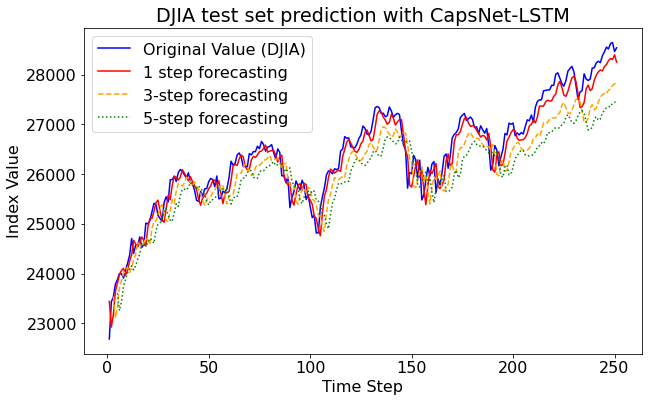

In [40]:
# Plot the forecast

plt.figure(figsize=(10, 6))

plt.plot(np.arange( 1, len(time_test)+1 ), series_test, linestyle='-', color='blue')

plt.plot(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_1, linestyle='-', color='Red')

plt.plot(np.arange( 3, len(time_test)+1 ), series_test_hat_capsnet_lstm_3, linestyle='--', color='Orange')

plt.plot(np.arange( 5, len(time_test)+1 ), series_test_hat_capsnet_lstm_5, linestyle=':', color='Green')

plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("DJIA test set prediction with CapsNet-LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (DJIA)", "1 step forecasting","3-step forecasting","5-step forecasting"], loc='upper left', frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Multistage/DJIA/figures/capsnet_lstm_forecasts_DJIA.tif")

In [41]:
rmse_capsnet_lstm_1, mae_capsnet_lstm_1, mape_capsnet_lstm_1= compute_metrics(series_test, series_test_hat_capsnet_lstm_1)

print(f"rmse: {rmse_capsnet_lstm_1:.2f}, mae: {mae_capsnet_lstm_1:.2f} , mape: {mape_capsnet_lstm_1:.2f} for 1-step forecast")

rmse: 233.07, mae: 186.40 , mape: 0.71 for 1-step forecast


In [42]:
smape_capsnet_lstm_1 = smape(series_test, series_test_hat_capsnet_lstm_1)
print(f"smape: {smape_capsnet_lstm_1:.2f} for 1-step forecast")

smape: 0.71 for 1-step forecast


In [43]:
rmse_capsnet_lstm_2, mae_capsnet_lstm_2, mape_capsnet_lstm_2= compute_metrics(series_test[1:], series_test_hat_capsnet_lstm_2)

print(f"rmse: {rmse_capsnet_lstm_2:.2f}, mae: {mae_capsnet_lstm_2:.2f} , mape: {mape_capsnet_lstm_2:.2f} for 2-step forecast")

rmse: 306.97, mae: 256.52 , mape: 0.97 for 2-step forecast


In [44]:
smape_capsnet_lstm_2 = smape(series_test[1:], series_test_hat_capsnet_lstm_2)
print(f"smape: {smape_capsnet_lstm_2:.2f} for 2-step forecast")

smape: 0.97 for 2-step forecast


In [45]:
rmse_capsnet_lstm_3, mae_capsnet_lstm_3, mape_capsnet_lstm_3= compute_metrics(series_test[2:], series_test_hat_capsnet_lstm_3)

print(f"rmse: {rmse_capsnet_lstm_3:.2f}, mae: {mae_capsnet_lstm_3:.2f} , mape: {mape_capsnet_lstm_3:.2f} for 3-step forecast")

rmse: 461.87, mae: 392.13 , mape: 1.47 for 3-step forecast


In [46]:
smape_capsnet_lstm_3 = smape(series_test[2:], series_test_hat_capsnet_lstm_3)
print(f"smape: {smape_capsnet_lstm_3:.2f} for 3-step forecast")

smape: 1.48 for 3-step forecast


In [47]:
rmse_capsnet_lstm_4, mae_capsnet_lstm_4, mape_capsnet_lstm_4= compute_metrics(series_test[3:], series_test_hat_capsnet_lstm_4)

print(f"rmse: {rmse_capsnet_lstm_4:.2f}, mae: {mae_capsnet_lstm_4:.2f} , mape: {mape_capsnet_lstm_4:.2f} for 4-step forecast")

rmse: 582.55, mae: 493.69 , mape: 1.84 for 4-step forecast


In [48]:
smape_capsnet_lstm_4 = smape(series_test[3:], series_test_hat_capsnet_lstm_4)
print(f"smape: {smape_capsnet_lstm_4:.2f} for 4-step forecast")

smape: 1.86 for 4-step forecast


In [49]:
rmse_capsnet_lstm_5, mae_capsnet_lstm_5, mape_capsnet_lstm_5= compute_metrics(series_test[4:], series_test_hat_capsnet_lstm_5)

print(f"rmse: {rmse_capsnet_lstm_5:.2f}, mae: {mae_capsnet_lstm_5:.2f} , mape: {mape_capsnet_lstm_5:.2f} for 5-step forecast")

rmse: 617.14, mae: 524.68 , mape: 1.96 for 5-step forecast


In [50]:
smape_capsnet_lstm_5 = smape(series_test[4:], series_test_hat_capsnet_lstm_5)
print(f"smape: {smape_capsnet_lstm_5:.2f} for 5-step forecast")

smape: 1.98 for 5-step forecast


In [51]:
# Save_weights model

capsnet_lstm.save_weights("/content/gdrive/MyDrive/Multistage/DJIA/models/capsnet_lstm_DJIA_MIMO.h5", overwrite=True, save_format=None, options=None)


In [52]:
# Save predicted values

np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/capsnet_lstm_predicted_test_DJIA_1.csv", 
           series_test_hat_capsnet_lstm_1.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/capsnet_lstm_predicted_test_DJIA_2.csv", 
           series_test_hat_capsnet_lstm_2.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/capsnet_lstm_predicted_test_DJIA_3.csv", 
           series_test_hat_capsnet_lstm_3.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/capsnet_lstm_predicted_test_DJIA_4.csv", 
           series_test_hat_capsnet_lstm_4.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/capsnet_lstm_predicted_test_DJIA_5.csv", 
           series_test_hat_capsnet_lstm_5.T, delimiter=",")


np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/capsnet_lstm_predicted_whole_DJIA.csv", 
           series_y_hat_capsnet_lstm.T, delimiter=",")

# Baseline (LSTM, GRU, RNN, CNN-LSTM)

## LSTM

In [53]:
# Build the model with the best hp.
def LSTM():
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.LSTM(200, input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.Dense(5)
    ])
    learning_rate = 0.0005
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=["mae"])

    return model

### Model training

In [54]:

with strategy.scope():
  lstm = LSTM()
    # Fit with the entire dataset.
lstm.fit(train_set_five_step, epochs=400,callbacks = [reduce_lr])  


Epoch 1/400
70/70 [==============================] - 7s 32ms/step - loss: 0.0019 - mae: 0.0330 - lr: 5.0000e-04
Epoch 2/400
70/70 [==============================] - 1s 18ms/step - loss: 0.0044 - mae: 0.0564 - lr: 5.0000e-04
Epoch 3/400
70/70 [==============================] - 1s 18ms/step - loss: 0.0095 - mae: 0.0806 - lr: 5.0000e-04
Epoch 4/400
70/70 [==============================] - 1s 18ms/step - loss: 0.0093 - mae: 0.0797 - lr: 5.0000e-04
Epoch 5/400
70/70 [==============================] - 1s 19ms/step - loss: 0.0064 - mae: 0.0672 - lr: 5.0000e-04
Epoch 6/400
70/70 [==============================] - 1s 19ms/step - loss: 0.0054 - mae: 0.0617 - lr: 5.0000e-04
Epoch 7/400
70/70 [==============================] - 1s 18ms/step - loss: 0.0040 - mae: 0.0518 - lr: 4.7500e-04
Epoch 8/400
70/70 [==============================] - 1s 18ms/step - loss: 0.0026 - mae: 0.0411 - lr: 4.7500e-04
Epoch 9/400
70/70 [==============================] - 1s 18ms/step - loss: 0.0014 - mae: 0.0286 - lr: 4.7

In [55]:
print(lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200)               161600    
                                                                 
 dense_1 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 162,605
Trainable params: 162,605
Non-trainable params: 0
_________________________________________________________________
None


### Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this we use the `compute_metrics` function:

At this point only the model that will perform the forecast is ready but we still need to compute the actual forecast.



Faster model forecasts


- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

Now compute the actual forecast:

In [56]:
# Evaluate each model and the ensemble on the test set
# remember the last predicted value is not in the test set. It should be removed when producing y_hat series.

lstm_pred =  model_forecast(lstm, series_norm, G.WINDOW_SIZE).squeeze()



78/78 [==============================] - 3s 16ms/step


In [57]:
lstm_pred = reverse_normalization(lstm_pred, series_train)


In [58]:
series_hat_lstm = lstm_pred

In [59]:
series_y_hat_lstm = np.array(list(series_hat_lstm[:-1]))

In [60]:
series_test = series_y[-G.SPLIT_TIME:]
series_test_hat_lstm_1 = series_y_hat_lstm[-G.SPLIT_TIME:,0]
series_test_hat_lstm_2 = series_y_hat_lstm[-G.SPLIT_TIME:-1,1]
series_test_hat_lstm_3 = series_y_hat_lstm[-G.SPLIT_TIME:-2,2]
series_test_hat_lstm_4 = series_y_hat_lstm[-G.SPLIT_TIME:-3,3]
series_test_hat_lstm_5 = series_y_hat_lstm[-G.SPLIT_TIME:-4,4]



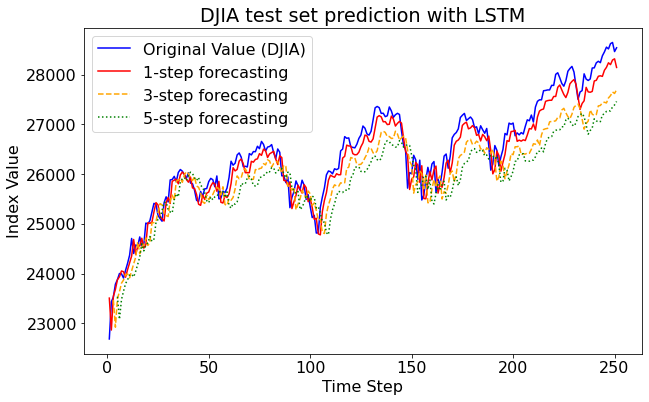

In [61]:
# Plot the forecast

plt.figure(figsize=(10, 6))

plt.plot(np.arange( 1, len(time_test)+1 ), series_test, linestyle='-', color='blue')

plt.plot(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_1, linestyle='-', color='Red')

plt.plot(np.arange( 3, len(time_test)+1 ), series_test_hat_lstm_3, linestyle='--', color='Orange')

plt.plot(np.arange( 5, len(time_test)+1 ), series_test_hat_lstm_5, linestyle=':', color='Green')

plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("DJIA test set prediction with LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (DJIA)", "1-step forecasting","3-step forecasting","5-step forecasting"], loc='upper left', frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Multistage/DJIA/figures/lstm_forecasts_DJIA.tif")

In [62]:
rmse_lstm_1, mae_lstm_1, mape_lstm_1= compute_metrics(series_test, series_test_hat_lstm_1)

print(f"rmse: {rmse_lstm_1:.2f}, mae: {mae_lstm_1:.2f} , mape: {mape_lstm_1:.2f} for 1-step forecast")

rmse: 252.50, mae: 207.25 , mape: 0.78 for 1-step forecast


In [63]:
smape_lstm_1= smape(series_test, series_test_hat_lstm_1)

print(f"smape: {smape_lstm_1:.2f} for 1-step forecast")

smape: 0.79 for 1-step forecast


In [64]:
rmse_lstm_2, mae_lstm_2, mape_lstm_2= compute_metrics(series_test[1:], series_test_hat_lstm_2)

print(f"rmse: {rmse_lstm_2:.2f}, mae: {mae_lstm_2:.2f} , mape: {mape_lstm_2:.2f} for 2-step forecast")

rmse: 338.98, mae: 292.92 , mape: 1.10 for 2-step forecast


In [65]:
smape_lstm_2= smape(series_test[1:], series_test_hat_lstm_2)

print(f"smape: {smape_lstm_2:.2f} for 2-step forecast")

smape: 1.11 for 2-step forecast


In [66]:
rmse_lstm_3, mae_lstm_3, mape_lstm_3= compute_metrics(series_test[2:], series_test_hat_lstm_3)

print(f"rmse: {rmse_lstm_3:.2f}, mae: {mae_lstm_3:.2f} , mape: {mape_lstm_3:.2f} for 3-step forecast")

rmse: 522.32, mae: 444.12 , mape: 1.66 for 3-step forecast


In [67]:
smape_lstm_3= smape(series_test[2:], series_test_hat_lstm_3)

print(f"smape: {smape_lstm_3:.2f} for 3-step forecast")

smape: 1.68 for 3-step forecast


In [68]:
rmse_lstm_4, mae_lstm_4, mape_lstm_4= compute_metrics(series_test[3:], series_test_hat_lstm_4)

print(f"rmse: {rmse_lstm_4:.2f}, mae: {mae_lstm_4:.2f} , mape: {mape_lstm_4:.2f} for 4-step forecast")

rmse: 606.50, mae: 520.32 , mape: 1.94 for 4-step forecast


In [69]:
smape_lstm_4= smape(series_test[3:], series_test_hat_lstm_4)

print(f"smape: {smape_lstm_4:.2f} for 4-step forecast")

smape: 1.97 for 4-step forecast


In [70]:
rmse_lstm_5, mae_lstm_5, mape_lstm_5= compute_metrics(series_test[4:], series_test_hat_lstm_5)

print(f"rmse: {rmse_lstm_5:.2f}, mae: {mae_lstm_5:.2f} , mape: {mape_lstm_5:.2f} for 5-step forecast")

rmse: 678.45, mae: 581.09 , mape: 2.17 for 5-step forecast


In [71]:
smape_lstm_5= smape(series_test[4:], series_test_hat_lstm_5)

print(f"smape: {smape_lstm_5:.2f} for 5-step forecast")

smape: 2.20 for 5-step forecast


In [72]:
# Save_weights model

lstm.save_weights("/content/gdrive/MyDrive/Multistage/DJIA/models/lstm_DJIA_MIMO.h5", overwrite=True, save_format=None, options=None)


In [73]:
# Save predicted values

np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/lstm_predicted_test_DJIA_1.csv", 
           series_test_hat_lstm_1.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/lstm_predicted_test_DJIA_2.csv", 
           series_test_hat_lstm_2.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/lstm_predicted_test_DJIA_3.csv", 
           series_test_hat_lstm_3.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/lstm_predicted_test_DJIA_4.csv", 
           series_test_hat_lstm_4.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/lstm_predicted_test_DJIA_5.csv", 
           series_test_hat_lstm_5.T, delimiter=",")


np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/lstm_predicted_whole_DJIA.csv", 
           series_y_hat_lstm.T, delimiter=",")

## RNN

In [74]:
# Build the model with the best hp.
def RNN():
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.SimpleRNN(200, input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.Dense(5)
    ])
    learning_rate = 0.0005
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=["mae"])

    return model

### Model training

In [75]:

with strategy.scope():
  rnn = RNN()
    # Fit with the entire dataset.
rnn.fit(train_set_five_step, epochs=400,callbacks = [reduce_lr])  


Epoch 1/400
70/70 [==============================] - 5s 26ms/step - loss: 0.0027 - mae: 0.0400 - lr: 5.0000e-04
Epoch 2/400
70/70 [==============================] - 1s 15ms/step - loss: 0.0017 - mae: 0.0313 - lr: 5.0000e-04
Epoch 3/400
70/70 [==============================] - 1s 16ms/step - loss: 9.9549e-04 - mae: 0.0236 - lr: 5.0000e-04
Epoch 4/400
70/70 [==============================] - 1s 15ms/step - loss: 8.9907e-04 - mae: 0.0229 - lr: 5.0000e-04
Epoch 5/400
70/70 [==============================] - 1s 15ms/step - loss: 6.7443e-04 - mae: 0.0194 - lr: 5.0000e-04
Epoch 6/400
70/70 [==============================] - 1s 15ms/step - loss: 6.0899e-04 - mae: 0.0185 - lr: 5.0000e-04
Epoch 7/400
70/70 [==============================] - 1s 15ms/step - loss: 5.5725e-04 - mae: 0.0174 - lr: 5.0000e-04
Epoch 8/400
70/70 [==============================] - 1s 16ms/step - loss: 5.2328e-04 - mae: 0.0166 - lr: 5.0000e-04
Epoch 9/400
70/70 [==============================] - 1s 18ms/step - loss: 4.8507

In [76]:
print(rnn.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 200)               40400     
                                                                 
 dense_2 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 41,405
Trainable params: 41,405
Non-trainable params: 0
_________________________________________________________________
None


### Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this we use the `compute_metrics` function:

At this point only the model that will perform the forecast is ready but we still need to compute the actual forecast.



Faster model forecasts


- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

Now compute the actual forecast:

In [77]:
# Evaluate each model and the ensemble on the test set
# remember the last predicted value is not in the test set. It should be removed when producing y_hat series.

rnn_pred =  model_forecast(rnn, series_norm, G.WINDOW_SIZE).squeeze()



78/78 [==============================] - 3s 12ms/step


In [78]:
rnn_pred = reverse_normalization(rnn_pred, series_train)


In [79]:
series_hat_rnn = rnn_pred

In [80]:
series_y_hat_rnn = np.array(list(series_hat_rnn[:-1]))

In [81]:
series_test = series_y[-G.SPLIT_TIME:]
series_test_hat_rnn_1 = series_y_hat_rnn[-G.SPLIT_TIME:,0]
series_test_hat_rnn_2 = series_y_hat_rnn[-G.SPLIT_TIME:-1,1]
series_test_hat_rnn_3 = series_y_hat_rnn[-G.SPLIT_TIME:-2,2]
series_test_hat_rnn_4 = series_y_hat_rnn[-G.SPLIT_TIME:-3,3]
series_test_hat_rnn_5 = series_y_hat_rnn[-G.SPLIT_TIME:-4,4]


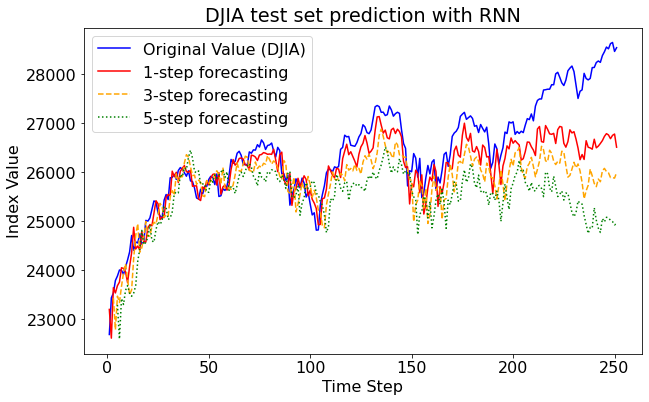

In [82]:
# Plot the forecast

plt.figure(figsize=(10, 6))

plt.plot(np.arange( 1, len(time_test)+1 ), series_test, linestyle='-', color='blue')

plt.plot(np.arange( 1, len(time_test)+1 ), series_test_hat_rnn_1, linestyle='-', color='Red')

plt.plot(np.arange( 3, len(time_test)+1 ), series_test_hat_rnn_3, linestyle='--', color='Orange')

plt.plot(np.arange( 5, len(time_test)+1 ), series_test_hat_rnn_5, linestyle=':', color='Green')

plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("DJIA test set prediction with RNN")
legend_drawn_flag = True
plt.legend(["Original Value (DJIA)", "1-step forecasting","3-step forecasting","5-step forecasting"], loc='upper left', frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Multistage/DJIA/figures/rnn_forecasts_DJIA.tif")

In [83]:
rmse_rnn_1, mae_rnn_1, mape_rnn_1= compute_metrics(series_test, series_test_hat_rnn_1)

print(f"rmse: {rmse_rnn_1:.2f}, mae: {mae_rnn_1:.2f} , mape: {mape_rnn_1:.2f} for 1-step forecast")

rmse: 636.50, mae: 446.09 , mape: 1.65 for 1-step forecast


In [84]:
smape_rnn_1= smape(series_test, series_test_hat_rnn_1)

print(f"smape: {smape_rnn_1:.2f} for 1-step forecast")

smape: 1.67 for 1-step forecast


In [85]:
rmse_rnn_2, mae_rnn_2, mape_rnn_2= compute_metrics(series_test[1:], series_test_hat_rnn_2)

print(f"rmse: {rmse_rnn_2:.2f}, mae: {mae_rnn_2:.2f} , mape: {mape_rnn_2:.2f} for 2-step forecast")

rmse: 796.88, mae: 583.24 , mape: 2.16 for 2-step forecast


In [86]:
smape_rnn_2= smape(series_test[1:], series_test_hat_rnn_2)

print(f"smape: {smape_rnn_2:.2f} for 2-step forecast")

smape: 2.20 for 2-step forecast


In [87]:
rmse_rnn_3, mae_rnn_3, mape_rnn_3= compute_metrics(series_test[2:], series_test_hat_rnn_3)

print(f"rmse: {rmse_rnn_3:.2f}, mae: {mae_rnn_3:.2f} , mape: {mape_rnn_3:.2f} for 3-step forecast")

rmse: 963.34, mae: 715.47 , mape: 2.64 for 3-step forecast


In [88]:
smape_rnn_3= smape(series_test[2:], series_test_hat_rnn_3)

print(f"smape: {smape_rnn_3:.2f} for 3-step forecast")

smape: 2.70 for 3-step forecast


In [89]:
rmse_rnn_4, mae_rnn_4, mape_rnn_4= compute_metrics(series_test[3:], series_test_hat_rnn_4)

print(f"rmse: {rmse_rnn_4:.2f}, mae: {mae_rnn_4:.2f} , mape: {mape_rnn_4:.2f} for 4-step forecast")

rmse: 1183.11, mae: 871.35 , mape: 3.21 for 4-step forecast


In [90]:
smape_rnn_4= smape(series_test[3:], series_test_hat_rnn_4)

print(f"smape: {smape_rnn_4:.2f} for 4-step forecast")

smape: 3.31 for 4-step forecast


In [91]:
rmse_rnn_5, mae_rnn_5, mape_rnn_5= compute_metrics(series_test[4:], series_test_hat_rnn_5)

print(f"rmse: {rmse_rnn_5:.2f}, mae: {mae_rnn_5:.2f} , mape: {mape_rnn_5:.2f} for 5-step forecast")

rmse: 1343.31, mae: 1019.67 , mape: 3.77 for 5-step forecast


In [92]:
smape_rnn_5= smape(series_test[4:], series_test_hat_rnn_5)

print(f"smape: {smape_rnn_5:.2f} for 5-step forecast")

smape: 3.89 for 5-step forecast


In [93]:
# Save_weights model

rnn.save_weights("/content/gdrive/MyDrive/Multistage/DJIA/models/rnn_DJIA_MIMO.h5", overwrite=True, save_format=None, options=None)


In [94]:
# Save predicted values

np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/rnn_predicted_test_DJIA_1.csv", 
           series_test_hat_rnn_1.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/rnn_predicted_test_DJIA_2.csv", 
           series_test_hat_rnn_2.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/rnn_predicted_test_DJIA_3.csv", 
           series_test_hat_rnn_3.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/rnn_predicted_test_DJIA_4.csv", 
           series_test_hat_rnn_4.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/rnn_predicted_test_DJIA_5.csv", 
           series_test_hat_rnn_5.T, delimiter=",")


np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/rnn_predicted_whole_DJIA.csv", 
           series_y_hat_rnn.T, delimiter=",")

## CNN-LSTM

In [95]:
def CNN_LSTM():
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=256, kernel_size=2,
                                 strides=1,
                                 activation="relu",
                                 padding='causal',
                                 input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="same"),
          tf.keras.layers.LSTM(200),
          tf.keras.layers.Dense(5)
    ])
    learning_rate = 0.0005
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=["mae"])

    return model

### Model training

In [96]:

with strategy.scope():
  cnn_lstm = CNN_LSTM()
    # Fit with the entire dataset.
cnn_lstm.fit(train_set_five_step, epochs=400,callbacks = [reduce_lr])  


Epoch 1/400
70/70 [==============================] - 8s 38ms/step - loss: 0.0012 - mae: 0.0268 - lr: 5.0000e-04
Epoch 2/400
70/70 [==============================] - 1s 20ms/step - loss: 0.0025 - mae: 0.0414 - lr: 5.0000e-04
Epoch 3/400
70/70 [==============================] - 1s 19ms/step - loss: 0.0042 - mae: 0.0480 - lr: 5.0000e-04
Epoch 4/400
70/70 [==============================] - 1s 19ms/step - loss: 0.0024 - mae: 0.0379 - lr: 5.0000e-04
Epoch 5/400
70/70 [==============================] - 1s 20ms/step - loss: 0.0016 - mae: 0.0309 - lr: 5.0000e-04
Epoch 6/400
70/70 [==============================] - 1s 20ms/step - loss: 8.5592e-04 - mae: 0.0229 - lr: 5.0000e-04
Epoch 7/400
70/70 [==============================] - 1s 19ms/step - loss: 5.2599e-04 - mae: 0.0176 - lr: 5.0000e-04
Epoch 8/400
70/70 [==============================] - 1s 20ms/step - loss: 4.3066e-04 - mae: 0.0153 - lr: 5.0000e-04
Epoch 9/400
70/70 [==============================] - 1s 20ms/step - loss: 4.1826e-04 - mae: 

In [97]:
print(cnn_lstm.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 256)           768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 256)          0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 200)               365600    
                                                                 
 dense_3 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 367,373
Trainable params: 367,373
Non-trainable params: 0
_________________________________________________________________
None


### Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this we use the `compute_metrics` function:

At this point only the model that will perform the forecast is ready but we still need to compute the actual forecast.



Faster model forecasts


- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

Now compute the actual forecast:

In [98]:
# Evaluate each model and the ensemble on the test set
# remember the last predicted value is not in the test set. It should be removed when producing y_hat series.

cnn_lstm_pred =  model_forecast(cnn_lstm, series_norm, G.WINDOW_SIZE).squeeze()



78/78 [==============================] - 4s 15ms/step


In [99]:
cnn_lstm_pred = reverse_normalization(cnn_lstm_pred, series_train)


In [100]:
series_hat_cnn_lstm = cnn_lstm_pred

In [101]:
series_y_hat_cnn_lstm = np.array(list(series_hat_cnn_lstm[:-1]))

In [102]:
series_test = series_y[-G.SPLIT_TIME:]
series_test_hat_cnn_lstm_1 = series_y_hat_cnn_lstm[-G.SPLIT_TIME:,0]
series_test_hat_cnn_lstm_2 = series_y_hat_cnn_lstm[-G.SPLIT_TIME:-1,1]
series_test_hat_cnn_lstm_3 = series_y_hat_cnn_lstm[-G.SPLIT_TIME:-2,2]
series_test_hat_cnn_lstm_4 = series_y_hat_cnn_lstm[-G.SPLIT_TIME:-3,3]
series_test_hat_cnn_lstm_5 = series_y_hat_cnn_lstm[-G.SPLIT_TIME:-4,4]


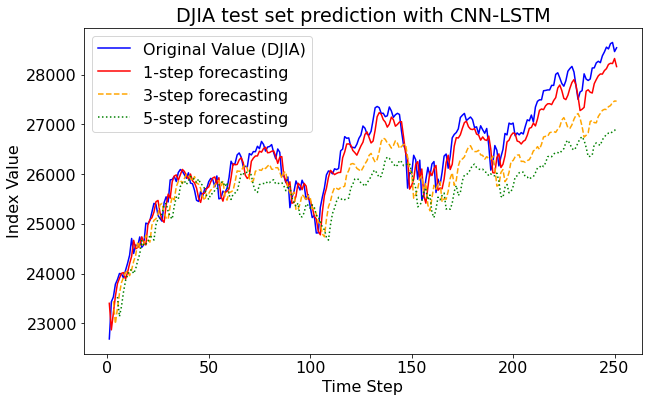

In [103]:
# Plot the forecast

plt.figure(figsize=(10, 6))

plt.plot(np.arange( 1, len(time_test)+1 ), series_test, linestyle='-', color='blue')

plt.plot(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_1, linestyle='-', color='Red')

plt.plot(np.arange( 3, len(time_test)+1 ), series_test_hat_cnn_lstm_3, linestyle='--', color='Orange')

plt.plot(np.arange( 5, len(time_test)+1 ), series_test_hat_cnn_lstm_5, linestyle=':', color='Green')

plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("DJIA test set prediction with CNN-LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (DJIA)", "1-step forecasting","3-step forecasting","5-step forecasting"], loc='upper left', frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Multistage/DJIA/figures/cnn_lstm_forecasts_DJIA.tif")

In [104]:
rmse_cnn_lstm_1, mae_cnn_lstm_1, mape_cnn_lstm_1= compute_metrics(series_test, series_test_hat_cnn_lstm_1)

print(f"rmse: {rmse_cnn_lstm_1:.2f}, mae: {mae_cnn_lstm_1:.2f} , mape: {mape_cnn_lstm_1:.2f} for 1-step forecast")

rmse: 254.62, mae: 208.06 , mape: 0.79 for 1-step forecast


In [105]:
smape_cnn_lstm_1= smape(series_test, series_test_hat_cnn_lstm_1)

print(f"smape: {smape_cnn_lstm_1:.2f} for 1-step forecast")

smape: 0.79 for 1-step forecast


In [106]:
rmse_cnn_lstm_2, mae_cnn_lstm_2, mape_cnn_lstm_2= compute_metrics(series_test[1:], series_test_hat_cnn_lstm_2)

print(f"rmse: {rmse_cnn_lstm_2:.2f}, mae: {mae_cnn_lstm_2:.2f} , mape: {mape_cnn_lstm_2:.2f} for 2-step forecast")

rmse: 443.43, mae: 374.45 , mape: 1.40 for 2-step forecast


In [107]:
smape_cnn_lstm_2= smape(series_test[1:], series_test_hat_cnn_lstm_2)

print(f"smape: {smape_cnn_lstm_2:.2f} for 2-step forecast")

smape: 1.41 for 2-step forecast


In [108]:
rmse_cnn_lstm_3, mae_cnn_lstm_3, mape_cnn_lstm_3= compute_metrics(series_test[2:], series_test_hat_cnn_lstm_3)

print(f"rmse: {rmse_cnn_lstm_3:.2f}, mae: {mae_cnn_lstm_3:.2f} , mape: {mape_cnn_lstm_3:.2f} for 3-step forecast")

rmse: 611.06, mae: 512.39 , mape: 1.91 for 3-step forecast


In [109]:
smape_cnn_lstm_3= smape(series_test[2:], series_test_hat_cnn_lstm_3)

print(f"smape: {smape_cnn_lstm_3:.2f} for 3-step forecast")

smape: 1.93 for 3-step forecast


In [110]:
rmse_cnn_lstm_4, mae_cnn_lstm_4, mape_cnn_lstm_4= compute_metrics(series_test[3:], series_test_hat_cnn_lstm_4)

print(f"rmse: {rmse_cnn_lstm_4:.2f}, mae: {mae_cnn_lstm_4:.2f} , mape: {mape_cnn_lstm_4:.2f} for 4-step forecast")

rmse: 759.05, mae: 639.93 , mape: 2.38 for 4-step forecast


In [111]:
smape_cnn_lstm_4= smape(series_test[3:], series_test_hat_cnn_lstm_4)

print(f"smape: {smape_cnn_lstm_4:.2f} for 4-step forecast")

smape: 2.42 for 4-step forecast


In [112]:
rmse_cnn_lstm_5, mae_cnn_lstm_5, mape_cnn_lstm_5= compute_metrics(series_test[4:], series_test_hat_cnn_lstm_5)

print(f"rmse: {rmse_cnn_lstm_5:.2f}, mae: {mae_cnn_lstm_5:.2f} , mape: {mape_cnn_lstm_5:.2f} for 5-step forecast")

rmse: 898.95, mae: 760.34 , mape: 2.82 for 5-step forecast


In [113]:
smape_cnn_lstm_5= smape(series_test[4:], series_test_hat_cnn_lstm_5)

print(f"smape: {smape_cnn_lstm_5:.2f} for 5-step forecast")

smape: 2.88 for 5-step forecast


In [114]:
# Save_weights model

cnn_lstm.save_weights("/content/gdrive/MyDrive/Multistage/DJIA/models/cnn_lstm_DJIA_MIMO.h5", overwrite=True, save_format=None, options=None)


In [115]:
# Save predicted values

np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/cnn_lstm_predicted_test_DJIA_1.csv", 
           series_test_hat_cnn_lstm_1.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/cnn_lstm_predicted_test_DJIA_2.csv", 
           series_test_hat_cnn_lstm_2.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/cnn_lstm_predicted_test_DJIA_3.csv", 
           series_test_hat_cnn_lstm_3.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/cnn_lstm_predicted_test_DJIA_4.csv", 
           series_test_hat_cnn_lstm_4.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/cnn_lstm_predicted_test_DJIA_5.csv", 
           series_test_hat_cnn_lstm_5.T, delimiter=",")


np.savetxt("/content/gdrive/MyDrive/Multistage/DJIA/files/cnn_lstm_predicted_whole_DJIA.csv", 
           series_y_hat_cnn_lstm.T, delimiter=",")

# Plot together

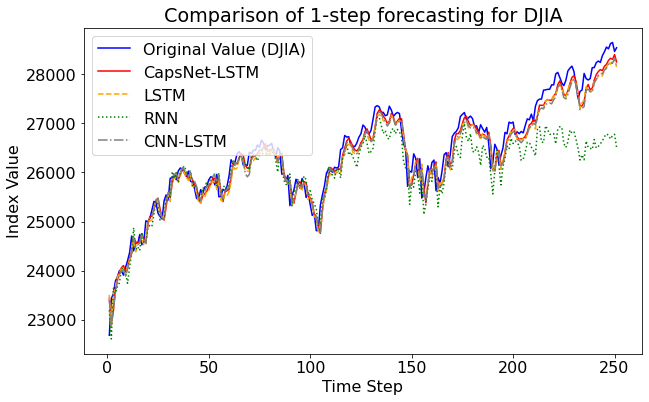

In [116]:
# Plot the forecast

plt.figure(figsize=(10, 6))

plt.plot(np.arange( 1, len(time_test)+1 ), series_test, linestyle='-', color='blue')

plt.plot(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_1, linestyle='-', color='Red')

plt.plot(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_1, linestyle='--', color='Orange')

plt.plot(np.arange( 1, len(time_test)+1 ), series_test_hat_rnn_1, linestyle=':', color='Green')

plt.plot(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_1, linestyle='-.', color='Grey')

plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("Comparison of 1-step forecasting for DJIA")
legend_drawn_flag = True
plt.legend(["Original Value (DJIA)", "CapsNet-LSTM","LSTM","RNN","CNN-LSTM"], loc='upper left', frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Multistage/DJIA/figures/comparison_forecasts_1_step_DJIA.tif")


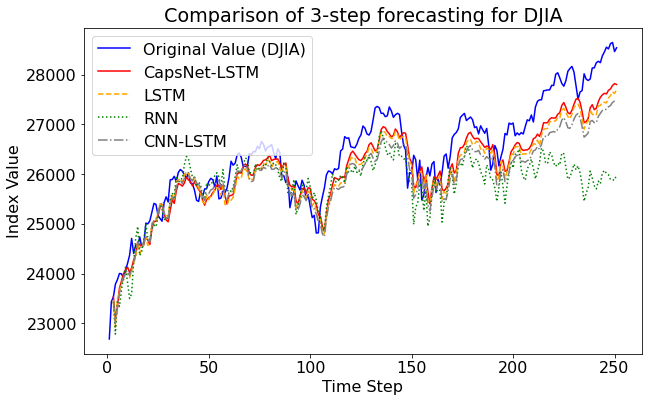

In [117]:
# Plot the forecast

plt.figure(figsize=(10, 6))

plt.plot(np.arange( 1, len(time_test)+1 ), series_test, linestyle='-', color='blue')

plt.plot(np.arange( 3, len(time_test)+1 ), series_test_hat_capsnet_lstm_3, linestyle='-', color='Red')

plt.plot(np.arange( 3, len(time_test)+1 ), series_test_hat_lstm_3, linestyle='--', color='Orange')

plt.plot(np.arange( 3, len(time_test)+1 ), series_test_hat_rnn_3, linestyle=':', color='Green')

plt.plot(np.arange( 3, len(time_test)+1 ), series_test_hat_cnn_lstm_3, linestyle='-.', color='Grey')

plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("Comparison of 3-step forecasting for DJIA")
legend_drawn_flag = True
plt.legend(["Original Value (DJIA)", "CapsNet-LSTM","LSTM","RNN","CNN-LSTM"], loc='upper left', frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Multistage/DJIA/figures/comparison_forecasts_3_step_DJIA.tif")

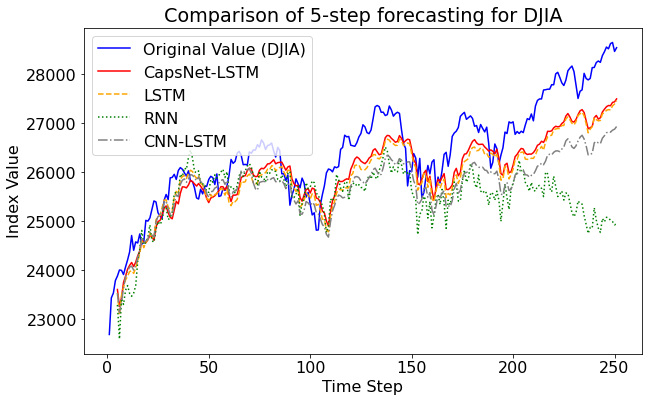

In [118]:
# Plot the forecast

plt.figure(figsize=(10, 6))

plt.plot(np.arange( 1, len(time_test)+1 ), series_test, linestyle='-', color='blue')

plt.plot(np.arange( 5, len(time_test)+1 ), series_test_hat_capsnet_lstm_5, linestyle='-', color='Red')

plt.plot(np.arange( 5, len(time_test)+1 ), series_test_hat_lstm_5, linestyle='--', color='Orange')

plt.plot(np.arange( 5, len(time_test)+1 ), series_test_hat_rnn_5, linestyle=':', color='Green')

plt.plot(np.arange( 5, len(time_test)+1 ), series_test_hat_cnn_lstm_5, linestyle='-.', color='Grey')

plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("Comparison of 5-step forecasting for DJIA")
legend_drawn_flag = True
plt.legend(["Original Value (DJIA)", "CapsNet-LSTM","LSTM","RNN","CNN-LSTM"], loc='upper left', frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Multistage/DJIA/figures/comparison_forecasts_5_step_DJIA.tif")

RMSE:

In [119]:
rmse_capsnet_lstm = [rmse_capsnet_lstm_1,rmse_capsnet_lstm_2,rmse_capsnet_lstm_3,rmse_capsnet_lstm_4,rmse_capsnet_lstm_5]

In [120]:
rmse_lstm = [rmse_lstm_1,rmse_lstm_2,rmse_lstm_3,rmse_lstm_4,rmse_lstm_5]

In [121]:
rmse_rnn = [rmse_rnn_1,rmse_rnn_2,rmse_rnn_3,rmse_rnn_4,rmse_rnn_5]

In [122]:
rmse_cnn_lstm = [rmse_cnn_lstm_1,rmse_cnn_lstm_2,rmse_cnn_lstm_3,rmse_cnn_lstm_4,rmse_cnn_lstm_5]

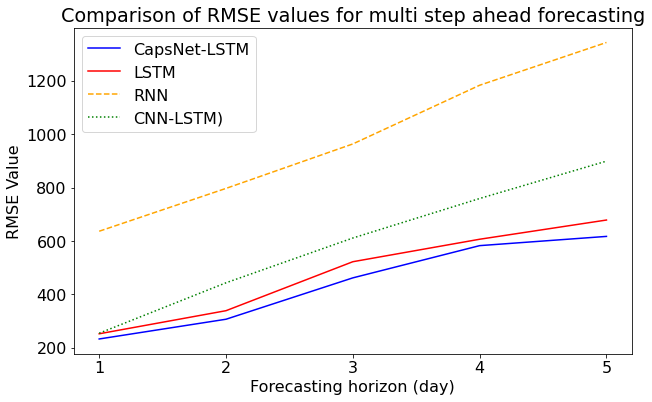

In [123]:
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = '16'
plt.plot(np.arange( 1, 6 ), rmse_capsnet_lstm,linestyle='-', color='blue')
plt.plot(np.arange( 1, 6 ), rmse_lstm,linestyle='-', color='Red')
plt.plot(np.arange( 1, 6 ), rmse_rnn,linestyle='--', color='Orange')
plt.plot(np.arange( 1, 6 ), rmse_cnn_lstm,linestyle=':', color='Green')

plt.ylabel("RMSE Value")
plt.xlabel("Forecasting horizon (day)")
plt.xticks(np.arange(1, 6, 1))
plt.title("Comparison of RMSE values for multi step ahead forecasting")
legend_drawn_flag = True
plt.legend(["CapsNet-LSTM","LSTM","RNN","CNN-LSTM)"], loc='upper left', frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Multistage/DJIA/figures/rmse_5_steps_DJIA.tif")

MAE:

In [124]:
mae_capsnet_lstm = [mae_capsnet_lstm_1,mae_capsnet_lstm_2,mae_capsnet_lstm_3,mae_capsnet_lstm_4,mae_capsnet_lstm_5]

In [125]:
mae_lstm = [mae_lstm_1,mae_lstm_2,mae_lstm_3,mae_lstm_4,mae_lstm_5]

In [126]:
mae_rnn = [mae_rnn_1,mae_rnn_2,mae_rnn_3,mae_rnn_4,mae_rnn_5]

In [127]:
mae_cnn_lstm = [mae_cnn_lstm_1,mae_cnn_lstm_2,mae_cnn_lstm_3,mae_cnn_lstm_4,mae_cnn_lstm_5]

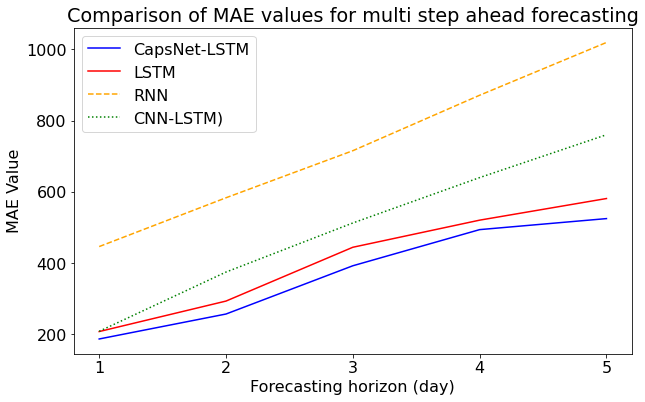

In [128]:
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = '16'
plt.plot(np.arange( 1, 6 ), mae_capsnet_lstm,linestyle='-', color='blue')
plt.plot(np.arange( 1, 6 ), mae_lstm,linestyle='-', color='Red')
plt.plot(np.arange( 1, 6 ), mae_rnn,linestyle='--', color='Orange')
plt.plot(np.arange( 1, 6 ), mae_cnn_lstm,linestyle=':', color='Green')

plt.ylabel("MAE Value")
plt.xlabel("Forecasting horizon (day)")
plt.xticks(np.arange(1, 6, 1))
plt.title("Comparison of MAE values for multi step ahead forecasting")
legend_drawn_flag = True
plt.legend(["CapsNet-LSTM","LSTM","RNN","CNN-LSTM)"], loc='upper left', frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Multistage/DJIA/figures/mae_5_steps_DJIA.tif")

MAPE:

In [129]:
mape_capsnet_lstm = [mape_capsnet_lstm_1,mape_capsnet_lstm_2,mape_capsnet_lstm_3,mape_capsnet_lstm_4,mape_capsnet_lstm_5]

In [130]:
mape_lstm = [mape_lstm_1,mape_lstm_2,mape_lstm_3,mape_lstm_4,mape_lstm_5]

In [131]:
mape_rnn = [mape_rnn_1,mape_rnn_2,mape_rnn_3,mape_rnn_4,mape_rnn_5]

In [132]:
mape_cnn_lstm = [mape_cnn_lstm_1,mape_cnn_lstm_2,mape_cnn_lstm_3,mape_cnn_lstm_4,mape_cnn_lstm_5]

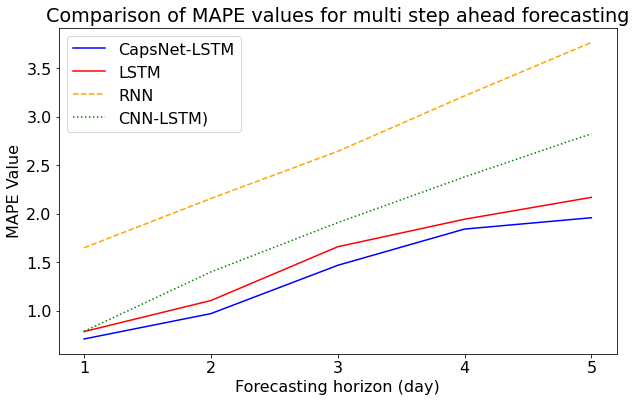

In [133]:
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = '16'
plt.plot(np.arange( 1, 6 ), mape_capsnet_lstm,linestyle='-', color='blue')
plt.plot(np.arange( 1, 6 ), mape_lstm,linestyle='-', color='Red')
plt.plot(np.arange( 1, 6 ), mape_rnn,linestyle='--', color='Orange')
plt.plot(np.arange( 1, 6 ), mape_cnn_lstm,linestyle=':', color='Green')

plt.ylabel("MAPE Value")
plt.xlabel("Forecasting horizon (day)")
plt.xticks(np.arange(1, 6, 1))
plt.title("Comparison of MAPE values for multi step ahead forecasting")
legend_drawn_flag = True
plt.legend(["CapsNet-LSTM","LSTM","RNN","CNN-LSTM)"], loc='upper left', frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Multistage/DJIA/figures/mape_5_steps_DJIA.tif")

In [134]:
smape_capsnet_lstm = [smape_capsnet_lstm_1,smape_capsnet_lstm_2,smape_capsnet_lstm_3,smape_capsnet_lstm_4,smape_capsnet_lstm_5]

In [135]:
smape_lstm = [smape_lstm_1,smape_lstm_2,smape_lstm_3,smape_lstm_4,smape_lstm_5]

In [136]:
smape_rnn = [smape_rnn_1,smape_rnn_2,smape_rnn_3,smape_rnn_4,smape_rnn_5]

In [137]:
smape_cnn_lstm = [smape_cnn_lstm_1,smape_cnn_lstm_2,smape_cnn_lstm_3,smape_cnn_lstm_4,smape_cnn_lstm_5]

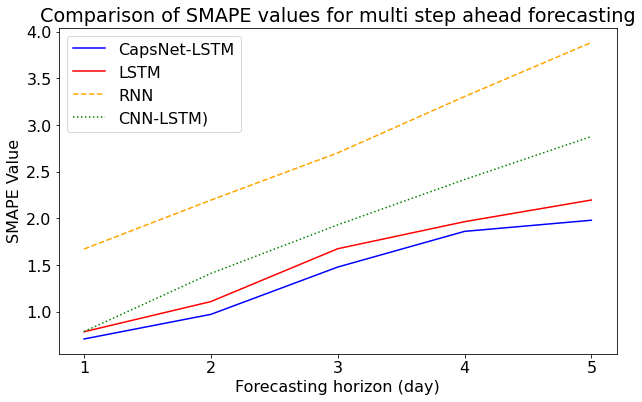

In [138]:
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = '16'
plt.plot(np.arange( 1, 6 ), smape_capsnet_lstm,linestyle='-', color='blue')
plt.plot(np.arange( 1, 6 ), smape_lstm,linestyle='-', color='Red')
plt.plot(np.arange( 1, 6 ), smape_rnn,linestyle='--', color='Orange')
plt.plot(np.arange( 1, 6 ), smape_cnn_lstm,linestyle=':', color='Green')

plt.ylabel("SMAPE Value")
plt.xlabel("Forecasting horizon (day)")
plt.xticks(np.arange(1, 6, 1))
plt.title("Comparison of SMAPE values for multi step ahead forecasting")
legend_drawn_flag = True
plt.legend(["CapsNet-LSTM","LSTM","RNN","CNN-LSTM)"], loc='upper left', frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Multistage/DJIA/figures/smape_5_steps_DJIA.tif")